In [104]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.color
import skimage.feature
import sklearn.ensemble
from matplotlib.colors import LinearSegmentedColormap
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [110]:
# Functions:

def daijkstra(chain, p_prior, u_prior):
    updated_chain = np.zeros((chain.shape[0]))
    paths = np.zeros((p_prior.shape[0], chain.shape[0])).astype(int) # param for saving all labels of the 5 paths
    path_costs = np.zeros((p_prior.shape[0])).astype(int)            # param for saving the summed up costs for each path 1-5
    temp_costs = np.zeros((p_prior.shape[0])).astype(int)            # param for temporarily save the cost for each possible path at a step 
    for x in range(chain.shape[0]-1):
        for state in range(p_prior.shape[0]):  # current node
            for next_state in range(p_prior.shape[0]):  # all paths that lead to that node
                temp_costs[next_state] =  p_prior[next_state][paths[next_state][x]] # get the cost for each possible path, next_state that leads to the node, state
                if(next_state == chain[x]):   # if the possible path equals to the posterior apply the unary prior to the cost
                    temp_costs[next_state] += u_prior
            paths[state][x+1] = np.random.choice(np.where(temp_costs == np.amin(temp_costs))[0]) # returns the label with minimum costs. If there are more multiple labels that share a minimum, one is randomly out of those selected
            path_costs[state] += temp_costs[paths[state][x+1]]
            
    return paths[np.argmin(path_costs)]  # return the labels of the path with the cumulated minimum costs

def get_p_prior_r(C1, C2):
    prior = np.ones((5, 5))
    prior[np.where(np.eye(5))] = 0
    for i in range(prior.shape[0]):
        for j in range(prior.shape[1]):
            if(abs(i-j)==1):
                prior[i][j]=C1
            if(abs(i-j)>1):
                prior[i][j]=C2
    return prior

def get_p_prior_c(C1, C2, C3):
    prior = np.ones((5, 5))
    prior[np.where(np.eye(5))] = 0
    for i in range(prior.shape[0]):
        for j in range(prior.shape[1]):
            if((j-i) <= -1 ):
                prior[i][j]=C3
            if((j-i) == -4):
                prior[i][j]=C1
            if((j-i) == 1):
                prior[i][j]=C1
            if((j-i) > 1):
                prior[i][j]=C2
    return prior


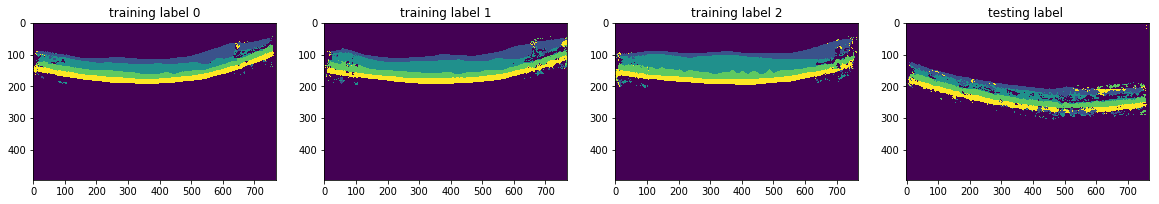

In [111]:
#EX 3b)

predictions_set = h5.File('predictions.h5','r')
pred_img = []

for key in predictions_set:
    pred_img.append(predictions_set[key][...])
    
predictions_set.close()
pred_img=np.array(pred_img)

test_label = np.argmax(pred_img[0], axis=2)
train_label = np.array([np.argmax(pred_img[1], axis=2), 
                        np.argmax(pred_img[2], axis=2), 
                        np.argmax(pred_img[3], axis=2)])

colors = ['w','r','b','g','y']
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=5)
fig,ax = plt.subplots(1,4)
for i in range(3):
    ax[i].imshow(train_label[i])
    ax[i].set_title("training label "+str(i))
ax[3].imshow(test_label)
ax[3].set_title("testing label ")
fig.set_size_inches(20,40)

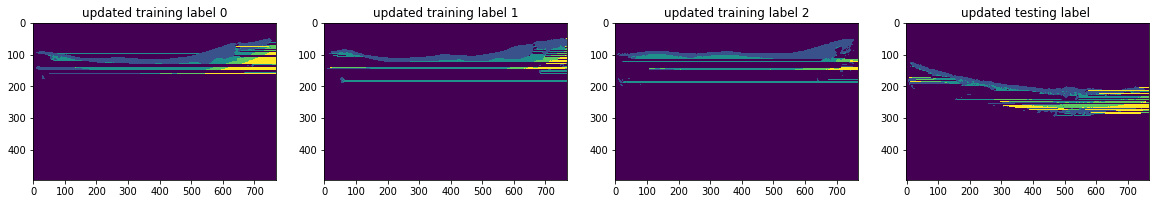

In [112]:
#EX 3c)

C1 = 2
C2 = 3
u_prior_r = -2

p_prior_r = get_p_prior_r(C1, C2)
#print(test_label[200])
#ret = daijkstra(test_label[200], p_prior, u_prior)
#print(ret)
updated_test_label = np.zeros((test_label.shape[0], 
                               test_label.shape[1]))
updated_train_label = np.zeros((train_label.shape[0], 
                                train_label.shape[1], 
                                train_label.shape[2]))

for i in range(test_label.shape[0]):
    updated_test_label[i] = daijkstra(test_label[i], p_prior_r, u_prior_r)
    for j in range(updated_train_label.shape[0]):
        updated_train_label[j][i] = daijkstra(train_label[j][i], p_prior_r, u_prior_r)
        
fig1,ax1 = plt.subplots(1,4)
for i in range(3):
    ax1[i].imshow(updated_train_label[i])
    ax1[i].set_title("updated training label "+str(i))
ax1[3].imshow(updated_test_label)
ax1[3].set_title("updated testing label ")
fig1.set_size_inches(20,40)

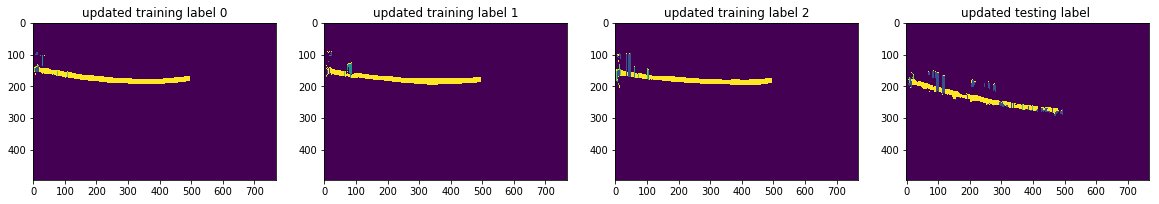

In [113]:
# EX 3e)
C1 = 1
C2 = 2*C1
C3 = 1000 * C1
u_prior_c = -3

p_prior_c = get_p_prior_c(C1, C2, C3)

transposed_train_label = np.zeros((train_label.shape[0], 
                                   train_label.shape[2], 
                                   train_label.shape[1]))
transposed_test_label = test_label.transpose()
transposed_train_label[0] = train_label[0].transpose()
transposed_train_label[1] = train_label[1].transpose()
transposed_train_label[2] = train_label[2].transpose()

transposed_updated_test_label = np.zeros((transposed_test_label.shape[0], 
                                          transposed_test_label.shape[1]))
transposed_updated_train_label = np.zeros((transposed_train_label.shape[0], 
                                           transposed_train_label.shape[1], 
                                           transposed_train_label.shape[2]))

for i in range(test_label.shape[0]):
    transposed_updated_test_label[i] = daijkstra(transposed_test_label[i], p_prior_c, u_prior_c)
    for j in range(updated_train_label.shape[0]):
        transposed_updated_train_label[j][i] = daijkstra(transposed_train_label[j][i], p_prior_c, u_prior_c)
        
updated_test_label = transposed_updated_test_label.transpose()
updated_train_label[0] = transposed_updated_train_label[0].transpose()
updated_train_label[1] = transposed_updated_train_label[1].transpose()
updated_train_label[2] = transposed_updated_train_label[2].transpose()

fig2,ax2 = plt.subplots(1,4)
for i in range(3):
    ax2[i].imshow(updated_train_label[i])
    ax2[i].set_title("updated training label "+str(i))
ax2[3].imshow(updated_test_label)
ax2[3].set_title("updated testing label ")
fig2.set_size_inches(20,40)